In [1]:
#pip install torchmetrics

In [1]:
import os
import torch
import torchmetrics
import torchvision
import numpy as np
from dataclasses import dataclass
from pathlib import Path
from torch import nn
from matplotlib import pyplot as plt
from sklearn.datasets import load_digits

%matplotlib inline

/home/yazansh/hdd/shai-courses/nlp-course-notebooks/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Introduction

The goal of this exercise is to implement a machine learning project using PyTorch and its ecosystem of packages.

The task at hand is MNIST image classification, given a grayscale image of handwritten image, the task is to classify the image and determine which digit it represents from (0-9)

The neural network that we will implement is a simple Feed Forward Neural Network (FFNN)

In this exercise we will be using the following extra packages for PyTorch:

1. [`torchvision`](https://pytorch.org/vision/stable/index.html): computer vision utility functions and extensions for PyTroch
2. [`torchmetrics`](https://torchmetrics.readthedocs.io/en/stable/all-metrics.html): ready to use metrics for evaluating a machine learning model

## Instructions

1. Some tasks are already done for you, with a link to the related documentation left for your reference
2. Tasks that you're required to do are labeled with `TODO`
3. Use search engines and the official documentation as much as you can to gain better insights on the topics at hand

## Workflow

1. Prepare the dataset and data loaders
2. Explore the dataset visually
3. Define the model architecture
4. Prepare for training, by creating loss function, optimizer and metric function
5. Create training scripts and train
6. Validate the results visually

## Setup Device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
print(device)

cuda


# Dataset

## Dataset 

In [5]:
# Create a local directory to store the dataset
data_dir = os.path.join(os.curdir, "data")
Path(data_dir).mkdir(exist_ok=True)

`torchvision` is part of PyTorch ecosystem, it has utilities for computer vision models.

We will first use the dataset submodule to import the *MNIST* dataset, you can find more details [here](https://pytorch.org/vision/stable/datasets.html)



In [6]:
# Create transform functions to apply to each image once it's downloaded
# REFERENCE: https://pytorch.org/vision/stable/transforms.html
transforms = torchvision.transforms.Compose(transforms=[
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: torch.flatten(x))
])

In [13]:
# TODO: Use torchvision datasets to load both MNSIT training and testing splits
# REFERENCE: https://pytorch.org/vision/stable/datasets.html

# COMMENT: use `os.path.join` instead of `data_dir + /train`, this will work on any operating system ie: Windows, ..etc
# https://stackoverflow.com/questions/13944387/why-use-os-path-join-over-string-concatenation

train_dataset = torchvision.datasets.MNIST(root=data_dir +'/train',transform=transforms,train=True,download=True)
test_dataset = torchvision.datasets.MNIST(root=data_dir +'/test',transform=transforms,train=False,download=True)

## DataLoader

In [15]:
# Define batch size
batch_size = 36

# TODO: Create dataloaders, allow shuffle and set the batch size to the defined variable
# REFERENCE: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders

# COMMENT: you're setting batch_size manually to 36, you should use the variable

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=36, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=36, shuffle=True)

## Exploration

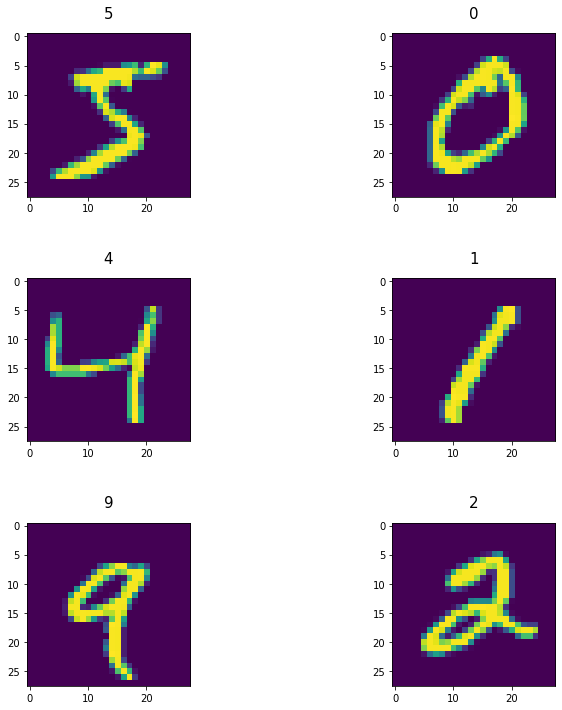

In [16]:
# Explore the dataset manually
samples = train_dataset.data[0:6]
labels = train_dataset.targets[0:6]

fig, axes = plt.subplots(figsize=(12, 12), nrows=3, ncols=2)

axes = np.array(axes).flatten()

for index, sample in enumerate(samples):
    axes[index].imshow(sample)
    axes[index].set_title(labels[index].item(), fontdict={"size": 15}, pad=15)
    

fig.subplots_adjust(hspace=0.5)

# Model

In [36]:
# The model class is created for you
# TODO: Define a three layer Feed Forward Neural Network (FFNN), 
# choose the input layer and output layer dimensions as appropriate, 
# and you can personally choose the hidden dimensions
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        # COMMENT: I prefer if the input dimension of the image to be set in the constructor `__init__(self, input_dim)`
        # This will ensure that any changes to the input dimension won't need a new model definition
        self.fc1 = nn.Linear(784,500)
        self.activation=nn.ReLU()
        self.fc2 = nn.Linear(500, 500, bias=True)
        self.fc3 = nn.Linear(500, 10, bias=True)
        self.softmax=nn.Softmax()
    
    # TODO: Define the fowrad function given an input image `x`
    # REMEMBER: To pass the input to a linear layer and apply an activation function of your choice afterwards
    # REMEMBER: The final output activation function is related to the loss function you'll use
    def forward(self, x):   
        output = self.fc1(x)
        output = self.activation(output)
        output = self.fc2(output)
        # COMMENT: why no activation after this layer?
        output = self.fc3(output)
        # COMMENT: you're using CrossRntropyLoss function, which includes a softmax itself, so this is unncessary 
        # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
        output = self.softmax(output)
        
        return output

In [37]:
# Instanciate the model class and move it to your device 
model = MNISTClassifier()
model = model.to(device)

# COMMENT: can be done in one line
model = MNISTClassifier().to(device)

In [38]:
print(model.parameters())
print(list(model.parameters()))

<generator object Module.parameters at 0x7f91af269380>
[Parameter containing:
tensor([[ 0.0135, -0.0004,  0.0132,  ...,  0.0343,  0.0282, -0.0219],
        [ 0.0271, -0.0111,  0.0126,  ..., -0.0029,  0.0093, -0.0197],
        [-0.0117,  0.0196, -0.0226,  ...,  0.0301,  0.0239, -0.0288],
        ...,
        [ 0.0244,  0.0033,  0.0125,  ...,  0.0099,  0.0085,  0.0043],
        [ 0.0259,  0.0272, -0.0326,  ...,  0.0280,  0.0050, -0.0344],
        [-0.0107, -0.0337, -0.0206,  ...,  0.0003,  0.0291,  0.0140]],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([-3.2255e-02, -2.0769e-02,  2.8952e-02, -2.6277e-02,  2.1270e-02,
         2.2932e-02,  9.0333e-04,  2.3972e-02, -2.8018e-02,  1.2790e-02,
         7.5220e-03,  2.4945e-04,  3.1209e-02,  2.7396e-02, -2.9294e-02,
        -5.8146e-03,  1.3409e-02, -1.9515e-02, -3.4587e-02, -3.0922e-02,
        -4.4743e-03, -2.7271e-02,  1.7060e-02, -2.0875e-02,  3.4006e-02,
        -7.4422e-03,  1.6211e-02, -1.7566e-02, -1.5395e-

# Training

In [39]:
# Define number of epochs for training
epochs = 20
learning_rate = 1e-4


# TODO: Define the optimizer, loss criterion
optim = torch.optim.Adam(model.parameters(), lr=learning_rate) 
critertion = nn.CrossEntropyLoss()


# TODO: Define a metric function (F1 Score) to evaluate the model
# REFERENCE: https://torchmetrics.readthedocs.io/en/stable/pages/overview.html
# REMEMBER: To move the metric function to the appropriate device


metric = torchmetrics.F1Score()
# COMMENT: This should be moved to the correct device!!
# https://torchmetrics.readthedocs.io/en/stable/pages/overview.html#metrics-and-devices
metric = torchmetrics.F1Score().to(device)

In [40]:
# A dataclass object defined to store the loss and metric results of each epoch
# REFERENCE: https://realpython.com/python-data-classes/
@dataclass
class Epoch:
    epoch: int
    training_loss: float
    validation_loss: float
    training_acc: float
    validation_acc: float
        
    
    def log(self) -> None:
        print(f"Epoch {self.epoch + 1}: Training Loss: {self.training_loss}\tValidation Loss: {self.validation_loss} || Training F1: {self.training_acc}\tValidation F1: {self.validation_acc}\n----------------------------------------------------")

Instructions for training script ***for each epoch***:

1. Set the initial epoch train and validation loss and metric to zero and reset the metric function
2. Set the model to training mode 
3. Load all batches in *train* dataloader
4. For each batch, unpack the inputs and target, move them to the correct device and pass them to the model to get predictions
5. Calculate loss and metric values for the prediction
6. Backpropagate the loss
7. Accumulate the epoch train loss and metric
8. Repeat the previous steps with appropriate changes to evaluate the model on the *test* data 
9. Store the epoch results in a history list

 

In [41]:
history: list[Epoch] = []

for epoch in range(epochs):
    # TODO: Define epoch train and test: loss and metrics
    epoch_train_loss = 0
    epoch_val_loss = 0
    epoch_train_f1=0
    epoch_val_f1=0

    # TODO: Make sure to reset the metric function
    metric.reset()
    
    # TODO: Set the model to training mode
    model.train()
    
    # Iterate train batches
    for batch in train_loader:
        
        # REMEMBER: you need to reset the optimizer in order to avoid incorrect accumulation of gradientrs 
        optim.zero_grad()
        
        # TODO: Unpack the batch and move it to the correct device
        inputs, target = batch
        inputs, target = inputs.to(device), target.to(device)

        # TODO: get prediction from model
        output =model(inputs) 
        
        # TODO: Calculate loss and metric
        loss = critertion(output, target)
        f1 = metric(preds=output,target=target)
        
        # TODO: Backward propagataion
        loss.backward()
        optim.step()
        
        # Accumulate train loss
        epoch_train_loss += loss.item()
    
    # Calculate epoch training metric
    epoch_train_f1 = round(metric.compute().item(), 3)
    print(f"Epoch {epoch + 1}: Loss = {epoch_train_loss / len(train_loader.dataset)}")
    
    # TODO: set the model to test mode
    model.eval()
    
    # Reset the metric function
    metric.reset()
    
    # Make sure PyTorch will run inference without tracking gradients for enhancing performance
    with torch.no_grad():
        # TODO: Load batches from `test_loader`
        for batch in test_loader :
            
            # TODO: Unpack the batch and move it to the correct device
            inputs, target = batch
            inputs, target = inputs.to(device), target.to(device)

            # TODO: get prediction from model
            output = model(inputs) 
            
            # TODO: Calculate loss and metric values
            loss = critertion(output, target)
            f1 = metric(preds=output,target=target)
            
            # TODO: Accumulate validation loss
            epoch_val_loss += loss.item()
            
        # TODO: Calculate epoch validation metric
        epoch_val_f1 =round(metric.compute().item(), 3) 
      

    # Calculate epoch training loss
    epoch_train_loss = round(epoch_train_loss / len(train_loader), 3)
    
    # TODO: Calculate epoch validation loss
    epoch_val_loss = round(epoch_val_loss / len(test_loader), 3)
    
    # TODO: Create `Epoch` instance with the results
    epoch_result = Epoch(epoch=epoch, 
                         training_loss=epoch_train_loss, 
                         validation_loss=epoch_val_loss,
                         training_acc=epoch_train_f1,
                         validation_acc=epoch_val_f1,
                        )
    
    # Add to history list
    history.append(epoch_result)
    
    # Log epoch output
    epoch_result.log()

/tmp/ipykernel_48910/1947080600.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.softmax(output)


KeyboardInterrupt: 

## Training History

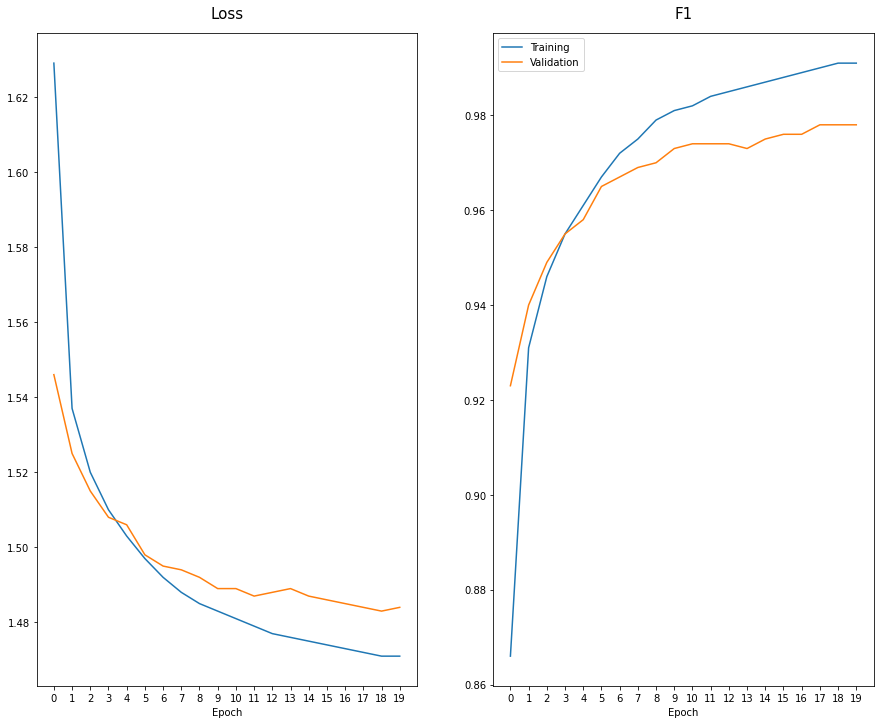

In [28]:
train_loss = list(map(lambda x: x.training_loss ,history))
val_loss = list(map(lambda x: x.validation_loss ,history))
train_acc = list(map(lambda x: x.training_acc, history))
val_acc = list(map(lambda x: x.validation_acc, history))

fig, (ax1, ax2) = plt.subplots(figsize=(15, 12), ncols=2)

ax1.plot(range(epochs), train_loss, label="Training")
ax1.plot(range(epochs), val_loss, label="Validation")

ax2.plot(range(epochs), train_acc, label="Training")
ax2.plot(range(epochs), val_acc, label="Validation")

ax1.set_title("Loss", fontdict=dict(size=15), pad=15)
ax2.set_title("F1", fontdict=dict(size=15), pad=15)

ax1.set_xticks(range(epochs))
ax2.set_xticks(range(epochs))

ax1.set_xlabel("Epoch")
ax2.set_xlabel("Epoch")

plt.legend()
plt.show()


# Visual Evaluation

/tmp/ipykernel_48910/1947080600.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.softmax(output)


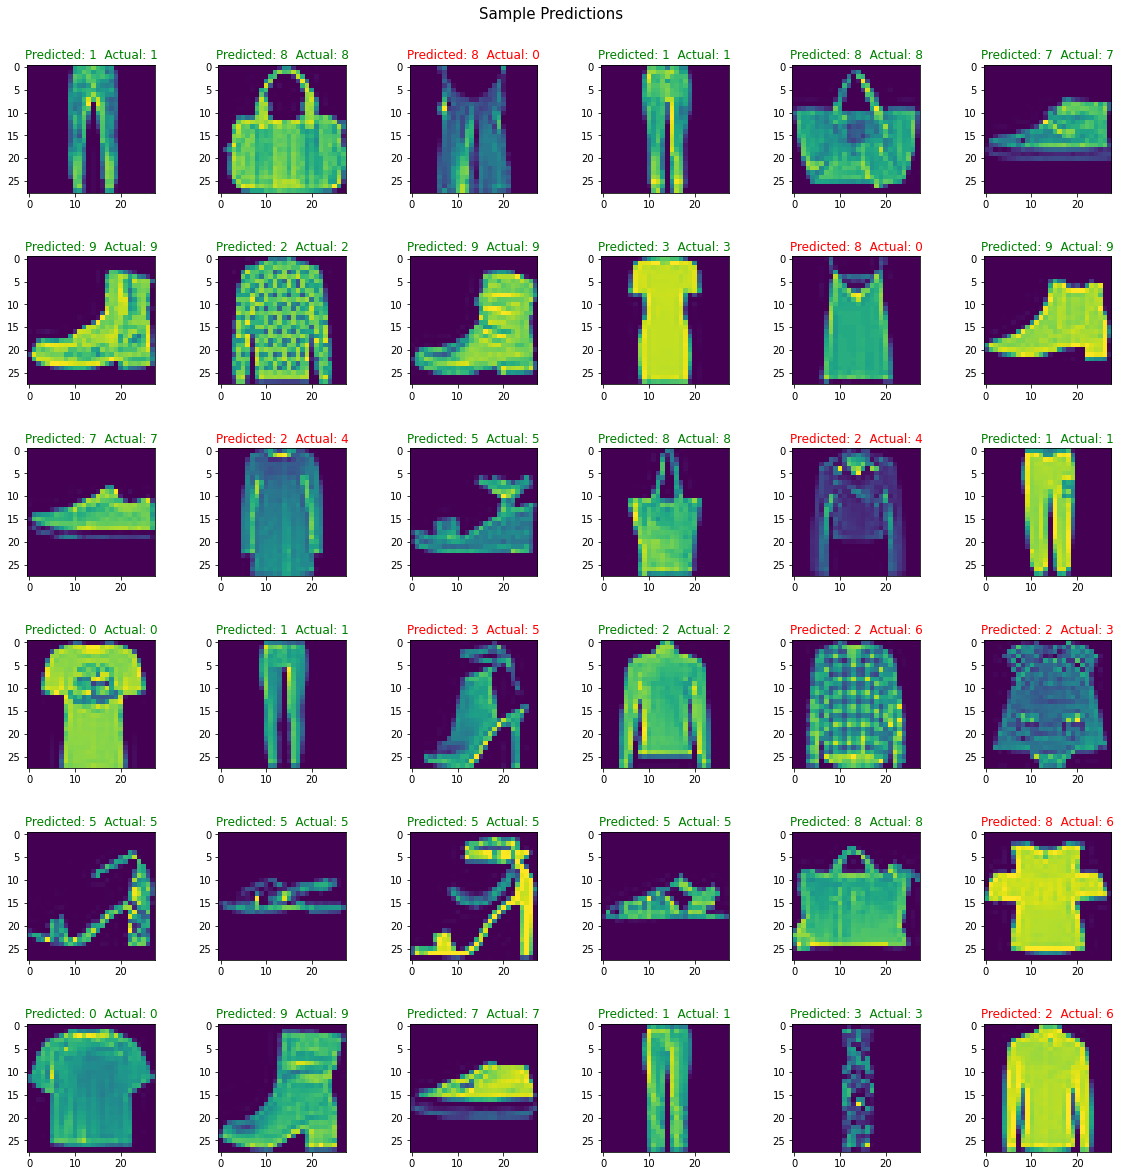

In [44]:
sample = next(iter(test_loader))
inputs, labels = sample


fig, axes = plt.subplots(figsize=(20, 20), ncols=6, nrows=6)

axes = np.array(axes).flatten()

model.eval()
for index in range(len(inputs)):
    im = inputs[index].unsqueeze(0)
    label = labels[index].item()
    
    prediction = model(im.to(device))
    prediction = torch.argmax(prediction).item()
    
    color = "green" if prediction == label else "red"
    axes[index].set_title(f"Predicted: {prediction}  Actual: {label}", color=color)
    
 
    axes[index].imshow(im.reshape((28, 28)))
    
    
fig.suptitle("Sample Predictions", y=0.92, fontsize=15)
fig.subplots_adjust(hspace=0.5)

# Extras

1. Train the model on the Fashion MNIST dataset
2. Create a deeper neural network
3. Try a different metric function

# Train the model on the Fashion MNIST dataset

In [45]:
# COMMENT: as before, use os.path.join
train_dataset = torchvision.datasets.FashionMNIST(root=data_dir +'/trainfashion',transform=transforms,train=True,download=True)
test_dataset = torchvision.datasets.FashionMNIST(root=data_dir +'/testfashion',transform=transforms,train=False,download=True)

In [46]:
# COMMENT: as before, use batch_size variable
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=36, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=36, shuffle=True)

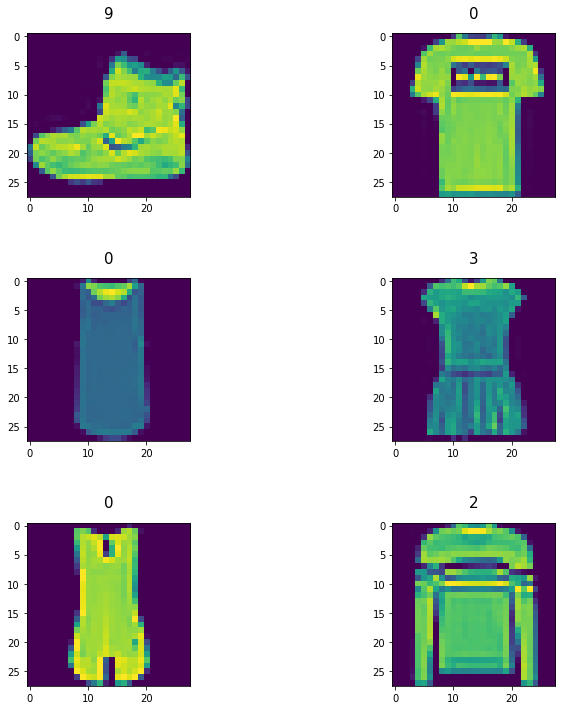

In [47]:
# Explore the dataset manually
samples = train_dataset.data[0:6]
labels = train_dataset.targets[0:6]

fig, axes = plt.subplots(figsize=(12, 12), nrows=3, ncols=2)

axes = np.array(axes).flatten()

for index, sample in enumerate(samples):
    axes[index].imshow(sample)
    axes[index].set_title(labels[index].item(), fontdict={"size": 15}, pad=15)
    

fig.subplots_adjust(hspace=0.5)

# Create a deeper neural network

In [50]:
# The model class is created for you
# TODO: Define a three layer Feed Forward Neural Network (FFNN), 
# choose the input layer and output layer dimensions as appropriate, 
# and you can personally choose the hidden dimensions

# COMMENT: you should rename this to FashionMNISTClassifier, as this name is misleading
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.fc1 = nn.Linear(784,120)
        self.activation=nn.ReLU()
        self.fc2 = nn.Linear(120, 120)
        self.fc3 = nn.Linear(120, 64)
        self.fc4 = nn.Linear(64, 10)
        self.softmax=nn.Softmax()
    
    # TODO: Define the fowrad function given an input image `x`
    # REMEMBER: To pass the input to a linear layer and apply an activation function of your choice afterwards
    # REMEMBER: The final output activation function is related to the loss function you'll use
    def forward(self, x):   
        output = self.fc1(x)
        output = self.activation(output)
        output = self.fc2(output)
        # COMMENT: why isn't there an activation function after these layers?
        output = self.fc3(output)
        output = self.fc4(output)
        # COMMENT: you're using CrossRntropyLoss function, which includes a softmax itself, so this is unncessary
        # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
        output = self.softmax(output)
        return output

In [52]:
# Instanciate the model class and move it to your device 
model = MNISTClassifier()
model = model.to(device)

# COMMENT: can be done in a single line, as before

In [53]:
# Define number of epochs for training
epochs = 5
learning_rate = 1e-4


# TODO: Define the optimizer, loss criterion
optim = torch.optim.Adam(model.parameters(), lr=learning_rate) 
critertion = nn.CrossEntropyLoss()


# Try a different metric function

In [57]:

metric = torchmetrics.FBetaScore()
# COMMENT: This should be moved to the correct device
metric = torchmetrics.FBetaScore().to(device)

In [58]:
history: list[Epoch] = []

for epoch in range(epochs):
    # TODO: Define epoch train and test: loss and metrics
    epoch_train_loss = 0
    epoch_val_loss = 0
    epoch_train_f1=0
    epoch_val_f1=0

    # TODO: Make sure to reset the metric function
    metric.reset()
    
    # TODO: Set the model to training mode
    model.train()
    
    # Iterate train batches
    for batch in train_loader:
        
        # REMEMBER: you need to reset the optimizer in order to avoid incorrect accumulation of gradientrs 
        optim.zero_grad()
        
        # TODO: Unpack the batch and move it to the correct device
        inputs, target = batch
        inputs, target = inputs.to(device), target.to(device)

        # TODO: get prediction from model
        output =model(inputs) 
        
        # TODO: Calculate loss and metric
        loss = critertion(output, target)
        f1 = metric(preds=output,target=target)
        
        # TODO: Backward propagataion
        loss.backward()
        optim.step()
        
        # Accumulate train loss
        epoch_train_loss += loss.item()
    
    # Calculate epoch training metric
    epoch_train_f1 = round(metric.compute().item(), 3)
    print(f"Epoch {epoch + 1}: Loss = {epoch_train_loss / len(train_loader.dataset)}")
    
    # TODO: set the model to test mode
    model.eval()
    
    # Reset the metric function
    metric.reset()
    
    # Make sure PyTorch will run inference without tracking gradients for enhancing performance
    with torch.no_grad():
        # TODO: Load batches from `test_loader`
        for batch in test_loader :
            
            # TODO: Unpack the batch and move it to the correct device
            inputs, target = batch
            inputs, target = inputs.to(device), target.to(device)

            # TODO: get prediction from model
            output = model(inputs) 
            
            # TODO: Calculate loss and metric values
            loss = critertion(output, target)
            f1 = metric(preds=output,target=target)
            
            # TODO: Accumulate validation loss
            epoch_val_loss += loss.item()
            
        # TODO: Calculate epoch validation metric
        epoch_val_f1 =round(metric.compute().item(), 3) 
      

    # Calculate epoch training loss
    epoch_train_loss = round(epoch_train_loss / len(train_loader), 3)
    
    # TODO: Calculate epoch validation loss
    epoch_val_loss = round(epoch_val_loss / len(test_loader), 3)
    
    # TODO: Create `Epoch` instance with the results
    epoch_result = Epoch(epoch=epoch, 
                         training_loss=epoch_train_loss, 
                         validation_loss=epoch_val_loss,
                         training_acc=epoch_train_f1,
                         validation_acc=epoch_val_f1,
                        )
    
    # Add to history list
    history.append(epoch_result)
    
    # Log epoch output
    epoch_result.log()

/tmp/ipykernel_48910/2800554051.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.softmax(output)


Epoch 1: Loss = 0.05023291939695676
Epoch 1: Training Loss: 1.808	Validation Loss: 1.701 || Training F1: 0.685	Validation F1: 0.771
----------------------------------------------------
Epoch 2: Loss = 0.04620599766969681
Epoch 2: Training Loss: 1.663	Validation Loss: 1.652 || Training F1: 0.81	Validation F1: 0.814
----------------------------------------------------
Epoch 3: Loss = 0.04541293786764145
Epoch 3: Training Loss: 1.635	Validation Loss: 1.64 || Training F1: 0.833	Validation F1: 0.827
----------------------------------------------------
Epoch 4: Loss = 0.045093872181574506
Epoch 4: Training Loss: 1.623	Validation Loss: 1.631 || Training F1: 0.843	Validation F1: 0.833
----------------------------------------------------
Epoch 5: Loss = 0.04489713978966077
Epoch 5: Training Loss: 1.616	Validation Loss: 1.626 || Training F1: 0.849	Validation F1: 0.84
----------------------------------------------------


/tmp/ipykernel_48910/2800554051.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.softmax(output)


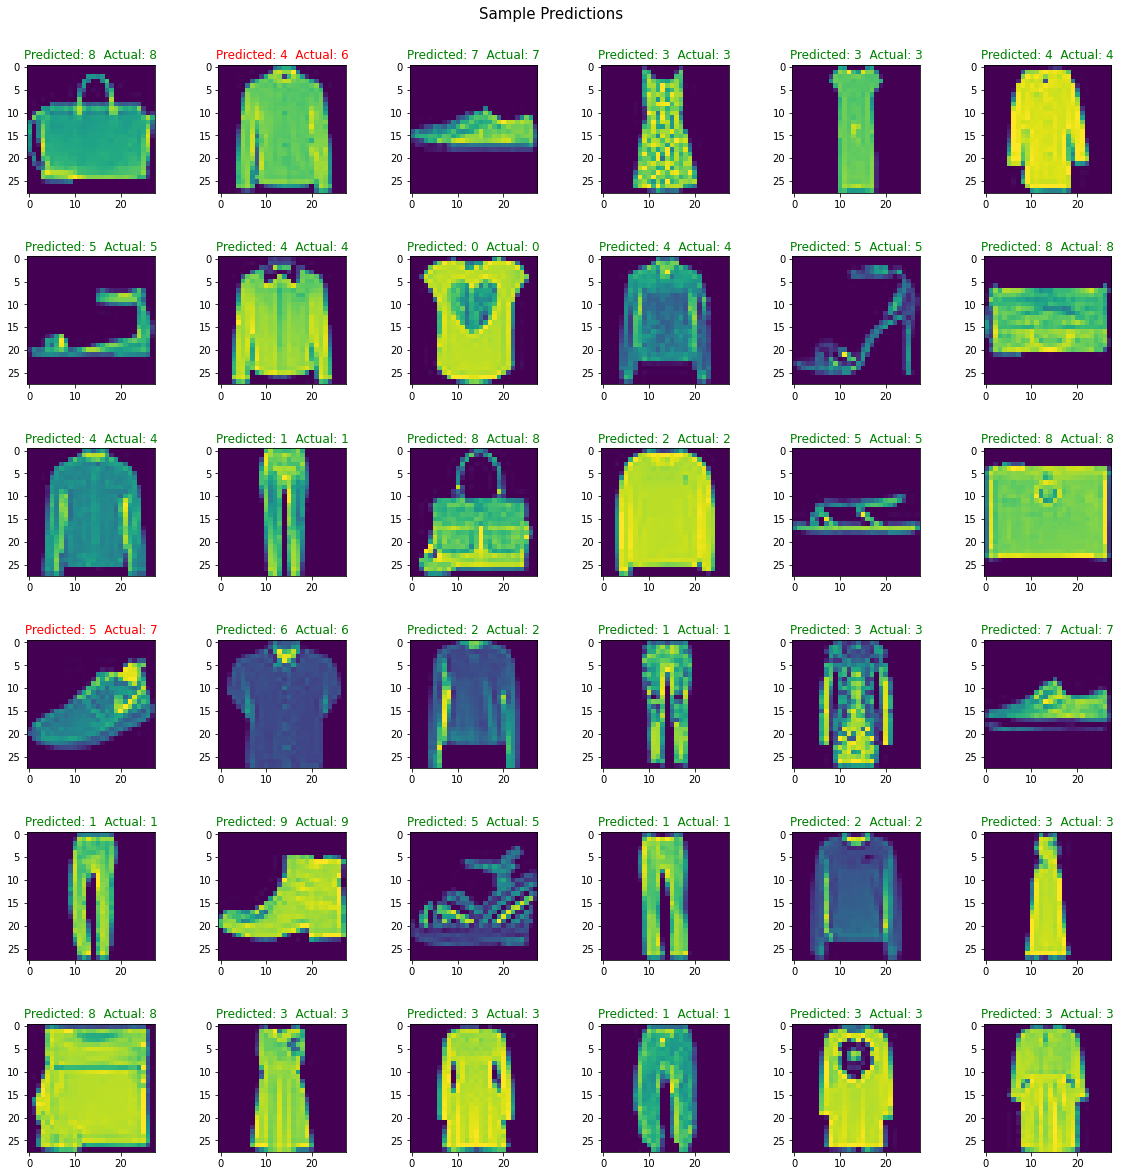

In [59]:
sample = next(iter(test_loader))
inputs, labels = sample


fig, axes = plt.subplots(figsize=(20, 20), ncols=6, nrows=6)

axes = np.array(axes).flatten()

model.eval()
for index in range(len(inputs)):
    im = inputs[index]
    label = labels[index].item()
    
    prediction = torch.softmax(model(im.to(device)), dim=-1)
    prediction = torch.argmax(prediction).item()
    
    color = "green" if prediction == label else "red"
    axes[index].set_title(f"Predicted: {prediction}  Actual: {label}", color=color)
    
 
    axes[index].imshow(im.reshape((28, 28)))
    
    
fig.suptitle("Sample Predictions", y=0.92, fontsize=15)
fig.subplots_adjust(hspace=0.5)